Matteo Picciolini

# Esercitazione 7

In [2]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import statsmodels.api as sm

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Risoluzione
Riprendo il codice dell'esercitazione 4 e correggo l'approssimazione relativa al raggio di cutoff. In tale esercitazione, infatti, si considera nulla l'interazione tra coppie di particelle con distanza maggiore a quella fissata dal raggio di cutoff. Naturalmente questa approssimazione è grossolana, ma c'è la possibiltà di tenere conto del contributo dell'interazione tra queste particelle attraverso le *tail corrections* di energia potenziale e pressione.

Si può dimostrare che per un potenziale di Lennard-Jones queste correzioni valgono rispettivamente:
$$
\frac{\langle U \rangle _{tail}}{N}   =8\pi\rho\epsilon \left[ \frac{1}{9 r_c^9} - \frac{1}{3 r_c^3} \right]
\qquad \qquad \frac{\langle W \rangle _{tail}}{3N\epsilon}   = 32\pi\rho        \left[            \frac{1}{9 r_c^9}           - \frac{1}{6 r_c^3}        \right]
$$
dove $\rho$ e $r_c$ sono espresse in unità nel sistema di Lennard Jones. Anche in questa esercitazione uso $\sigma=\epsilon = 1$.

Ho implementato queste correzioni nel codice dell'esercitazione 4, inserendo nella funzione `Input` queste due righe:

```c++
v_tail = (8 * M_PI * rho) * ((1 / (9 * pow(rcut, 9))) - (1 / (3 * pow(rcut, 3))));
w_tail = (32 * M_PI * rho) * ((1 / (9 * pow(rcut, 9))) - (1 / (6 * pow(rcut, 3))));
```
Dopodichè, ho sommato le *tail corrections* ai valori di pressione e energia potenziali calcolati instantaneamente.

#### Commenti sul codice

La struttura del codice è molto simile a quella dell'esercitazione 4, quindi si faccia riferimento al Jupyter Notebook dell'esercitazione 4 per eventuali dubbi sull'organizzazionde dei file di testo o della struttura del codice. Per completezza commento solo una modifica importante relativa all'*usage*. Ho aggiunto un'opzione in più da riga di comando rispetto all'esercitazione 4, per poter scegliere di generare o meno i file relativi ai risultati sui valori istantanei di $U/N$ (si veda l'esercizio 7.2):

```
Usage: ./Exercise_07.1 <phase> <equilibration> <print_instant>' with <phase> = {solid, liquid, gas}, <equilibration> = {true, false} and <print_Instant> = {true, false}
```

## Exercise 07.2

Use the MD/MC code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Risoluzione
Per queste simulazioni utilizzo gli stessi parametri dell'esercitazione 4 e per ottenere un *acceptance ratio* di circa il $50\%$, utilizzo le seguenti ampiezze di passo:
- fase solida: $\delta = 0.11$;
- fase liquida: $\delta = 0.2$;
- fase gassosa: $\delta = 5$.

#### Valori istantanei di $U/N$
Per implementare la richiesta ho aggiunto alla fine della funzione `Measure()` il seguente codice c++:

```c++
if(print_instant == "true"){
    instant_epot.open(std::string(ROOT_PATH) + "/Data/" + pattern + "_instant_epot.dat", std::ios::app);
    instant_pres.open(std::string(ROOT_PATH) + "/Data/" + pattern + "_instant_pres.dat", std::ios::app);

    instant_epot << walker[iv] / (int) npart + v_tail << std::endl;
    instant_pres << walker[iw] + w_tail << std::endl;

    instant_epot.close();
    instant_pres.close();
    }
```
che permette di salvare su file i valori istantanei dell'energia per particella. Ho poi proceduto alla fase di equilibrazione e successivamente a aquella di simulazione. Mostro di seguito i valori istantanei assunti dall'energia potenziale per una simulazione da $5 \times 10^5$ steps per tutte e tre le fasi.

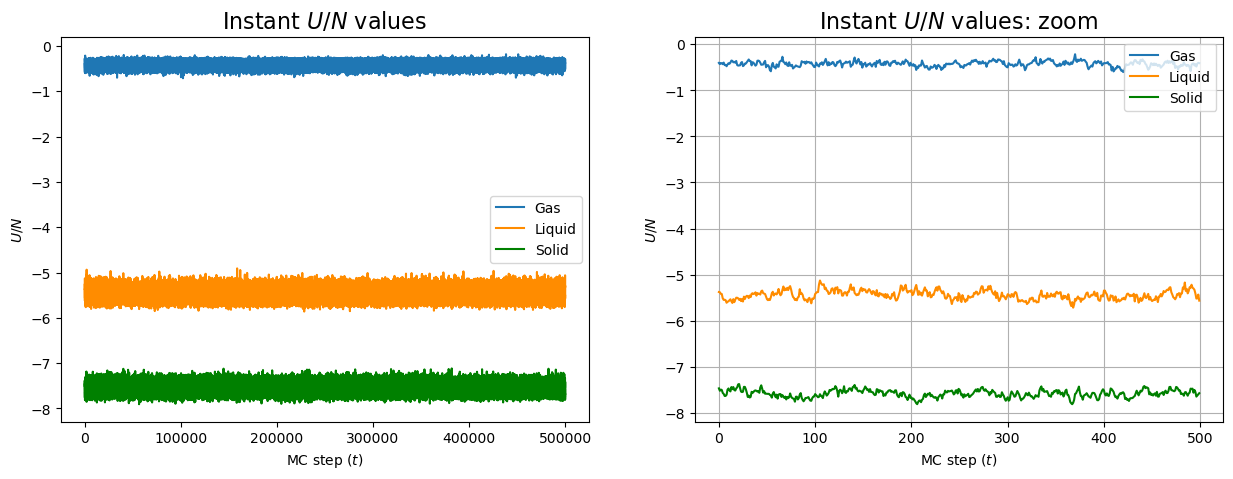

In [2]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

#Load Gas Data
gas_instant = np.loadtxt("../Data/07.1_instant_MC_gas_1.20_epot.dat")

#Load Liquid Data
liquid_instant = np.loadtxt("../Data/07.1_instant_MC_liquid_1.10_epot.dat")

#Load Solid Data
solid_instant = np.loadtxt("../Data/07.1_instant_MC_solid_0.80_epot.dat")

#plot
axs[0].plot(gas_instant, label = 'Gas')
axs[0].plot(liquid_instant, color = 'darkorange', label = 'Liquid')
axs[0].plot(solid_instant, color = 'green', label = 'Solid')

axs[0].set_ylabel('$U/N$')
axs[0].set_xlabel('MC step $(t)$')
axs[0].legend()
axs[0].set_title('Instant $U/N$ values', fontsize = 16) 

axs[1].plot(gas_instant[:500], label='Gas')
axs[1].plot(liquid_instant[:500], color='darkorange', label='Liquid')
axs[1].plot(solid_instant[:500], color='green', label='Solid')

axs[1].set_ylabel('$U/N$')
axs[1].set_xlabel('MC step $(t)$')
axs[1].legend(loc='upper right')


axs[1].set_title('Instant $U/N$ values: zoom', fontsize = 16) 
axs[1].grid()
plt.show()

#### Calcolo dell'autocorrelazione
Per implementare efficacemente il data blocking, è necessario stimare il "tempo" di autocorrelazione $\tau$ (misurato in unità di step MC) e assicurarsi che il numero di steps per blocco sia molto maggiore di $\tau$. Per fare ciò, utilizzo le $5\times 10^5$ estrazioni del paragrafo precedente per calcolarne l'autorrelazione.

In generale, l'autocorrelazione è uno strumento che definisce il grado di dipendenza tra i valori assunti da una funzione campionata nel suo dominio in ascissa. Essa misura, quindi, la correlazione tra i valori della funzione presi in punti diversi del dominio. L'autocorrelazione può essere utilizzata per valutare se i valori della funzione presentano una correlazione tra loro e se esistono pattern o ciclicità nel loro comportamento.

$$\text{Autocorrelation}(\text{lag}-k) = \frac{\sum\limits_{i=1}^{n-k} (x_i - \mu)(x_{i+k} - \mu)}{(n - k) \cdot \sigma^2}$$

Calcolo l'autocorrelazione nello specchietto python qui sotto, e ne mostro un grafico.

tau Gas: 2.7712013830204683
tau Liquid: 9.709595233416378
tau Solid: 8.25310756053899


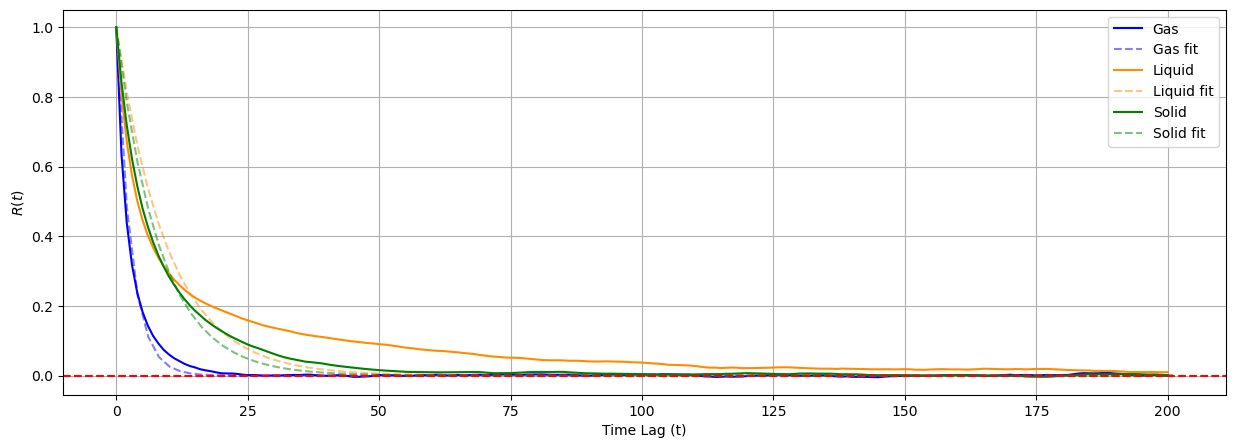

In [3]:
def exponential(x, a, b):
    return a * np.exp(-b * x)

def plot_autocorrelation(data, label, color):
    max_lag = 200
    
    # Calcolo dell'autocorrelazione
    acorr = sm.tsa.acf(data, nlags = max_lag)

    # Fitting esponenziale
    x = np.arange(len(acorr))
    popt, pcov = curve_fit(exponential, x, acorr, bounds = ([1, 0], [np.inf, np.inf]))
    a_fit, b_fit = popt

    # Calcolo di tau
    tau = 1 / b_fit
    print('tau {}: {}'.format(label, tau))

    # Generazione punti per la curva di fit
    x_fit = np.linspace(0, len(acorr), 100)
    y_fit = exponential(x_fit, a_fit, b_fit)

    # Creazione del grafico
    
    plt.plot(x, acorr, label = label, c = color)
    plt.plot(x_fit, y_fit, label = label + ' fit', c = color, ls = '--', alpha = 0.5)
    

plt.figure(figsize = (15, 5))

# Plot dell'autocorrelazione per i dati del gas
plot_autocorrelation(gas_instant, 'Gas', 'blue')
plot_autocorrelation(liquid_instant, 'Liquid', 'darkorange')
plot_autocorrelation(solid_instant, 'Solid', 'green')

plt.axhline(0, ls = '--', color = 'red')
plt.ylabel('$R(t)$')
plt.xlabel('Time Lag (t)')
plt.grid()
plt.legend()
plt.show()


A partire da questo grafico si può vedere come per ciascuna fase l'autocorrelazione decade dopo pochi steps. 

Inoltre, come ci si poteva aspettare, la fase gassosa mostra un'autocorrelazione temporale più breve. Questo fenomeno è dovuto alla presenza di uno stato altamente disordinato e di un potenziale relativamente debole rispetto all'energia cinetica. D'altra parte, la fase liquida presenta un tempo di autocorrelazione maggiore, sebbene sia ancora comparabile a quello della fase solida. 

Se i dati adiacenti sono correlati, l'incertezza statistica calcolata su di essi può essere sottostimata. Nel *data blocking*, infatti, i dati vengono suddivisi in blocchi di dimensioni specifiche e l'incertezza statistica viene calcolata all'interno di ciascun blocco. Se la dimensione dei blocchi è piccola rispetto alla distanza di autocorrelazione tra le misurazioni successive, l'incertezza statistica calcolata all'interno di ciascun blocco sarà sottostimata.

Questo accade perché la correlazione tra i dati adiacenti comporta una riduzione dell'informazione indipendente contenuta nei blocchi. Quindi, se i dati adiacenti sono correlati, l'incertezza statistica calcolata su blocchi di dimensioni piccole non tiene completamente conto della correlazione tra i dati, portando a una sottostima dell'incertezza effettiva sulla stima finale.

Per verificare l'andamento dell'incertezza statistica sulla stima finale di una grandezza come $U/N$, in funzione della dimensione dei blocchi, è possibile utilizzare i dati raccolti precedentemente. Coprendo un range di dimensioni dei blocchi da $L=M/N=10$ a $L=5\times 10^3$, dove $N$ è il numero di blocchi, $L$ è la dimensione del blocco e $M$ è il numero totale di steps, è possibile graficare come varia l'incertezza statistica al variare delle dimensioni dei blocchi e verificare se si osserva una sottostima quando i blocchi sono piccoli rispetto alla distanza di autocorrelazione tra le misurazioni successive.

Gas completed
Liquid completed
Solid completed


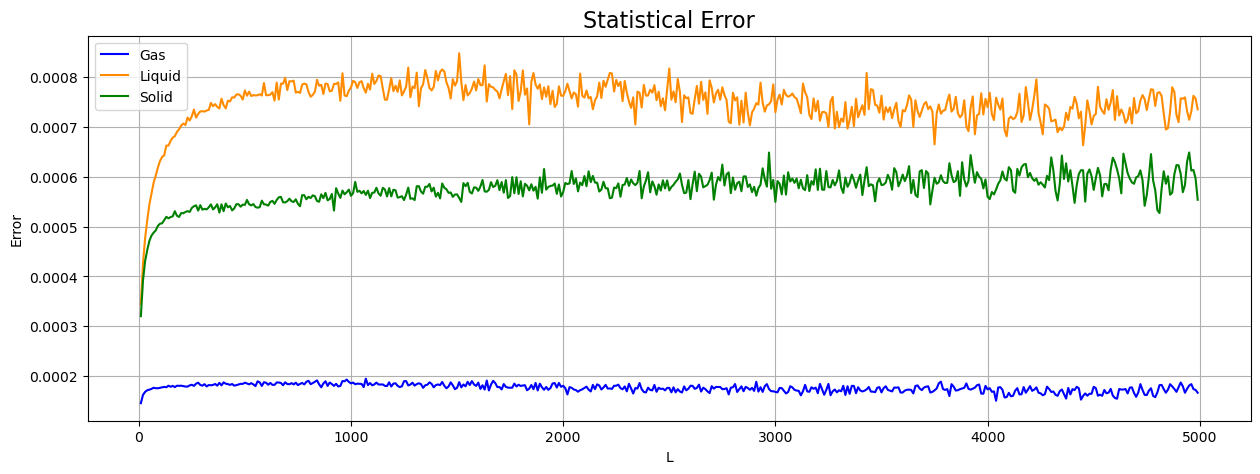

In [4]:
def calculate_error(average, average_squared, n):
    # Calcola l'errore a partire dalla media, la media al quadrato e il numero di campioni.
    if n == 0:
        return 0
    return np.sqrt((average_squared - average ** 2) / n)

def data_blocking_analysis(data, num_blocks, block_length):
    # Esegue l'analisi di data blocking su un insieme di dati.
    running_average = 0
    running_average_squared = 0
    error = 0

    for block_index in range(num_blocks):
        block_sum = 0

        for data_index in range(block_length):
            block_sum += data[data_index + block_index * block_length]

        block_mean = block_sum / block_length

        running_average = (running_average * block_index + block_mean) / (block_index + 1)
        running_average_squared = (running_average_squared * block_index + block_mean**2) / (block_index + 1)
        error = calculate_error(running_average, running_average_squared, block_index)

    return error


def plot_statistical_error(data, title, color):
    errors = []
    x_values = []
    L_range = range(L_min, L_max, 10)
    for L in L_range:
        N = int(M / L)
        err = data_blocking_analysis(data, N, L)
        errors.append(err)
        x_values.append(L)

    plt.plot(x_values, errors, label = title, color = color)
    
L_min = 10
L_max = 5000
M = 500000

fig = plt.figure(figsize = (15, 5))

plt.title("Statistical Error", fontsize = 16)

plot_statistical_error(gas_instant, 'Gas', 'blue')
print("Gas completed")
plot_statistical_error(liquid_instant, 'Liquid', 'darkorange')
print("Liquid completed")
plot_statistical_error(solid_instant, 'Solid', 'green')
print("Solid completed")

plt.legend()
plt.ylabel("Error")
plt.xlabel('L')
plt.grid(True)
plt.show()

A partire da questo grafico si può ricavare che una corretta dimensione dei blocchi deve essere di circa $2000$ blocchi per evitare di sosttostimare l'incertezza sulle misure.

## Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Risoluzione
A partire dai risultuati della sezione precedente, scelgo di impostare le simulazioni con $50$ blocchi da $2000$ passi. Per lanciare le simulazioni utilizzo il comando: `./Exercise_07.1 <phase> false false` per evitare di ristampare i valori istantanei di energia per particella.

Come richiesto, implemento nel codice il calcolo della funzione di distribuzione radiale $g(r)$ nell'intervallo $r \in \left[ 0; L/2\right]$, dove $r$ è la distanza tra coppie di particelle. La funzione di distribuzione radiale descrive la probabilità di trovare una particella a distanza $r$ da una particella di riferimento. La $g(r)$ si calcola come segue:
$$
g(r) =\frac{1}{\rho N\Delta V(r)} 
    \left\langle \sum_{i=1}^N \sum_{j=1,\neq i}^N \delta(r-|\vec r_i-\vec r_j |) \right\rangle
$$
dove $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$ è il volume di un guscio sferico in cui viene cercata la particella.

#### Commenti sul codice

Per stimare il valore della funzione di distribuzione radiale ho modificato la parte di codice relativa alla varibile `walker`. Le prime `n_props` posizioni di questo vettore, già a partire dall'esercitazione 4 erano occupate per il calcolo di energia potenziale, temperatura, emergia cinetica, pressione ed energia totale. La dimensione del vettore è sempre stata, però, di `m_props`, quindi questo mi ha suggerito di utilizzare le altre componenti vuote di questo vettore per risolvere la doppia sommatoria che compare nella formula di $g(r)$.

Per implementare questa *feature* ho, quindi, diviso l'intervallo $\left[ 0; L/2\right]$ in `n_bins = m_props - n_props` sottointervalli, e, ciclando sulle coppie di particelle, ho rimepito le componenti del vettore `walker` come se fossero bin di un istogramma, incrementando di due il bin corrispondente alla distanda `dr` tra due particelle.
Mostro il frammento di codice della funzione `Measure()` che riempie la variabile `walker`:
```c++
for (int i = 0; i < npart - 1; ++i){
    for (int j = i + 1; j < npart; ++j){
        
        [...]
        
        if(dr < box / 2.){
            walker[n_props + static_cast<int>(std::floor(dr / bin_size))] += 2;
        }
    }
}
```
dove `box = pow(vol, 1.0 / 3.0)`, `vol = (double)npart/rho` e `bin_size = box /  (2.0 * (double)n_bins)`. All'interno della funzione `Averages()`, che nell'esercitazione 4 si limitava a scrivere le medie calcolate su file di testo esterni, ho poi calcolato la media tenendo conto della normalizzazione e l'errore. Come al solito ho usato il metodo del *data blocking*, ma visto che i dati che uso sono relativi all'ultimo blocco, evito di calcare ogni volta anche l'errore sulla misura, risparmiando (poco) tempo computazionale. Non mostro frammenti di codice perché il calcolo che ho implementato ha la stessa forma di quello della pressione, escluso il ciclo `for` necessario per iterare su tutte le componenti di `walker`.

Mostro di seguito il risultato delle simulazioni.

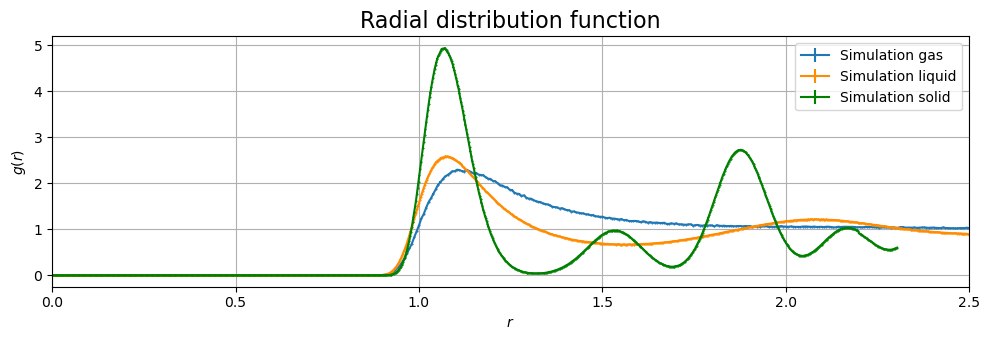

In [14]:
#GAS
plt.figure(figsize = (10,3.5))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation gas')
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation liquid', color = 'darkorange')
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation solid', color = 'green')
plt.title('Radial distribution function', fontsize = 16)
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.xlim(0,2.5)
plt.tight_layout()
plt.show()

Dai grafici, è evidente che il profilo della funzione di correlazione radiale g(r) sia coerente con il potenziale di Lennard-Jones. In particolare, non sono presenti particelle a distanze inferiori alla regione dove l'hard core repulsivo del potenziale diverge. Al contrario, intorno al minimo del potenziale, tutte e tre le fasi mostrano una struttura a "guscio", più o meno definito. Oltre a questo guscio, si osserva che sia la fase liquida che quella solida presentano ulteriori gusci, ma quelli della fase solida sono più definiti, come era atteso, poiché sono coerenti con una struttura ordinata simile a un reticolo cristallino.

## Exercise 07.4

By means of your upgraded MD/MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

### Risoluzione

Utilizzo ora tutte le *features* implementate nel codice per simulare lo stesso sistema sia con MC che con MD. Per decidere in che modalità si vuole far partire la simulazione è necessario modificare la prima riga del file `input-output/input.<phase>`. Per ottenere risultati consistenti con la modalità MD, è estremamente importante ricordarsi di modificare in questo file anche la voce `delta`, che stabilisce la lunghezza del passo. Per l'esercitazione 4 avevamo usato un passo di `0.0005`, quindi si può riutilizzare quello.

E' importante anche ricordarsi che le due tipologie di simulazioni hanno tempi e modalità diverse di equilibrazione. Per recuperare le informazioni riguardo l'equilibrazione per la simulazione MD si rimanda al Jupyter Notebook dell'esercitazione 4.

Come prima, utilizzo $50$ blocchi da $2000$ steps per entrambe le simulazioni.

Mostro di seguito i risultati che ho ottenuto per le varie fasi. I primi due grafici mostrano l'andamento di pressione e energia potenziale per particella, calcolate con simulazioni MC. Gli altri due grafici rappresentano rispettivamente l'andamento della funzione di distribuzione radiale per entrambe le modalità di simulazione e la differenza tra $g(r)$ calcolata con MD e $g(r)$ ottenuta tramite simulazione MC. L'ultimo grafico (quello della differenza) è particolarmente utile per confrontare le predizioni delle diverse simulazioni.

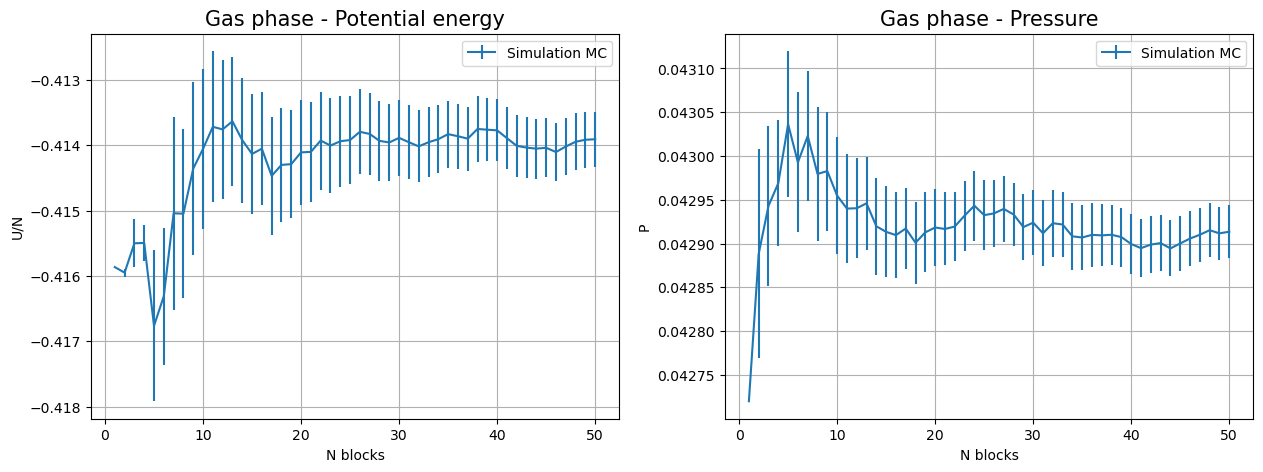

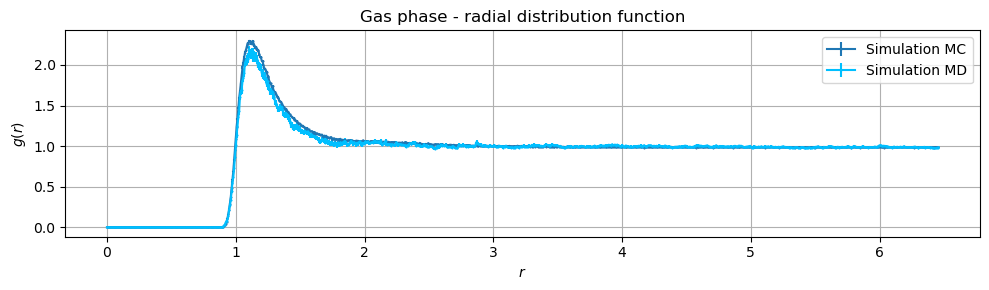

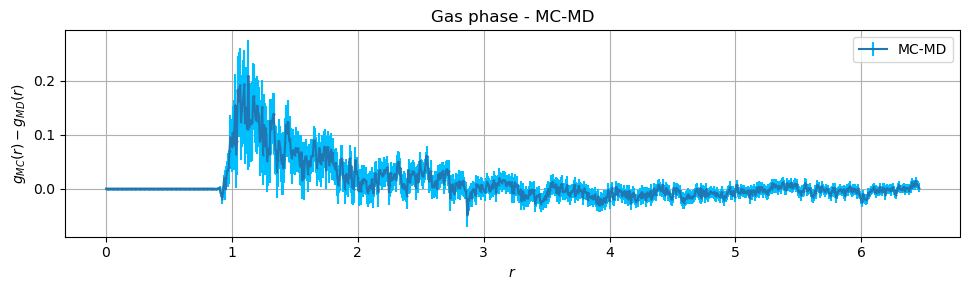

In [25]:
#GAS
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC")
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Gas phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC")
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Gas phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()

#GAS - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_gas_1.20_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'deepskyblue')
plt.title('Gas phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', ecolor = 'deepskyblue')
plt.title('Gas phase - MC-MD')
plt.ylabel('$g_{MC}(r)-g_{MD}(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

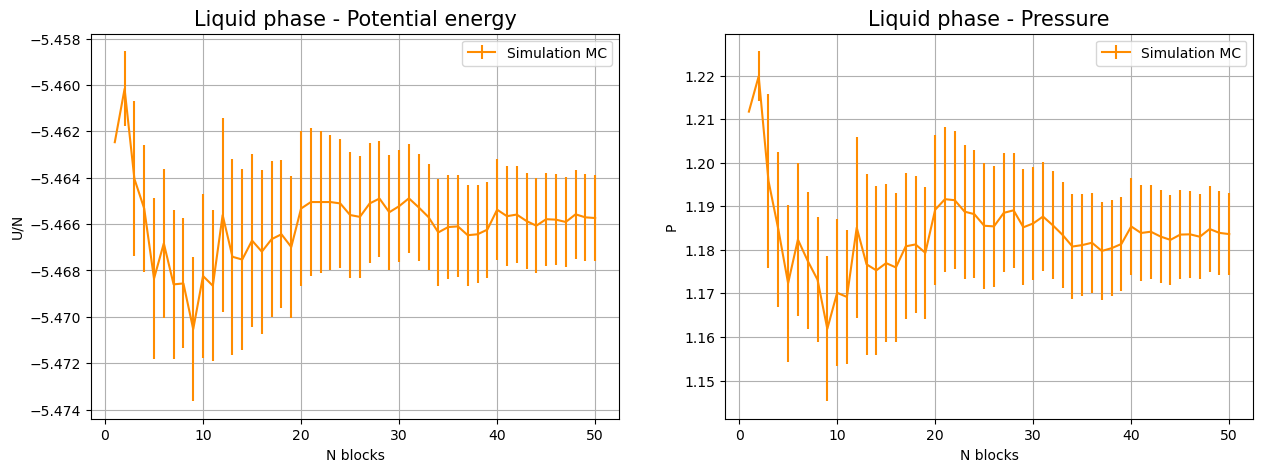

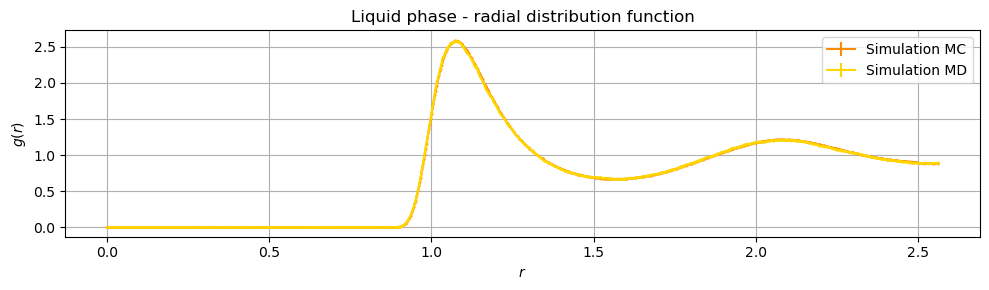

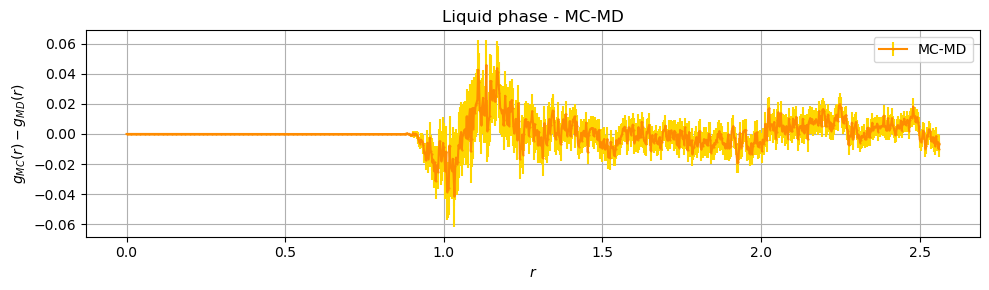

In [26]:
#LIQUID
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'darkorange')
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Liquid phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'darkorange')
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Liquid phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()


#LIQUID - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC', color = 'darkorange')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_liquid_1.10_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'gold')
plt.title('Liquid phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', color = 'darkorange', ecolor = 'gold')
plt.title('Liquid phase - MC-MD')
plt.ylabel('$g_{MC}(r)-g_{MD}(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

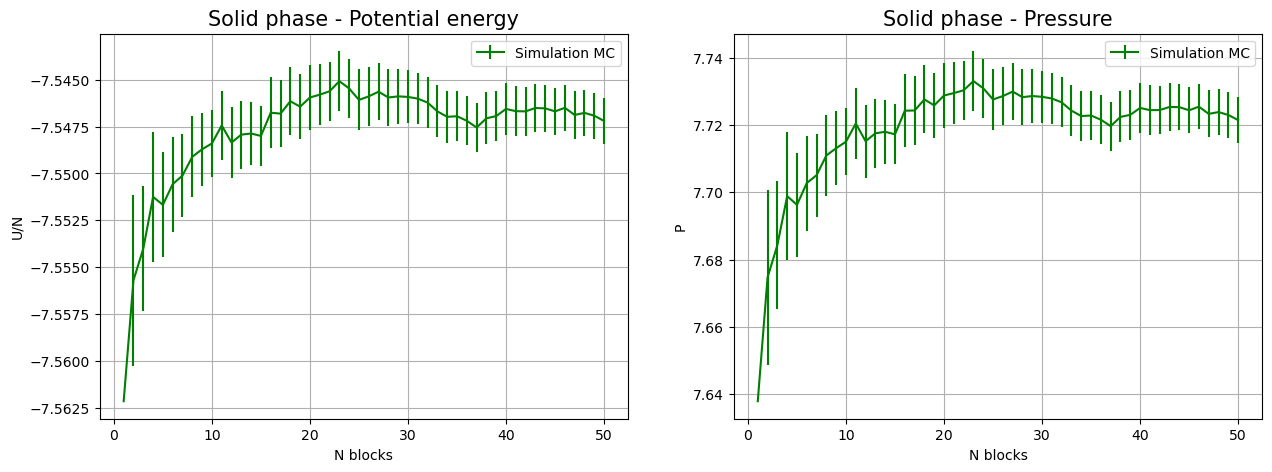

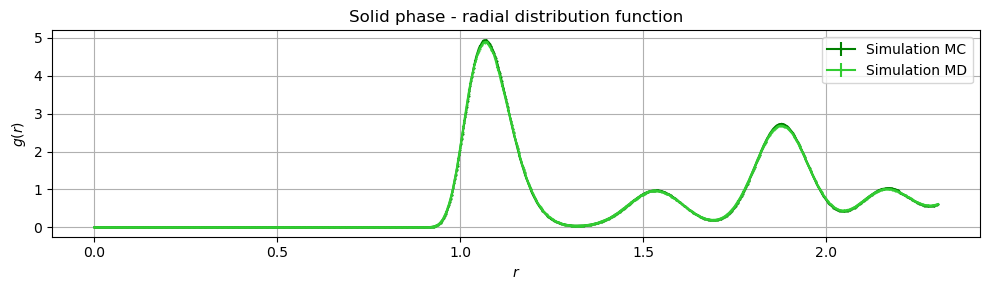

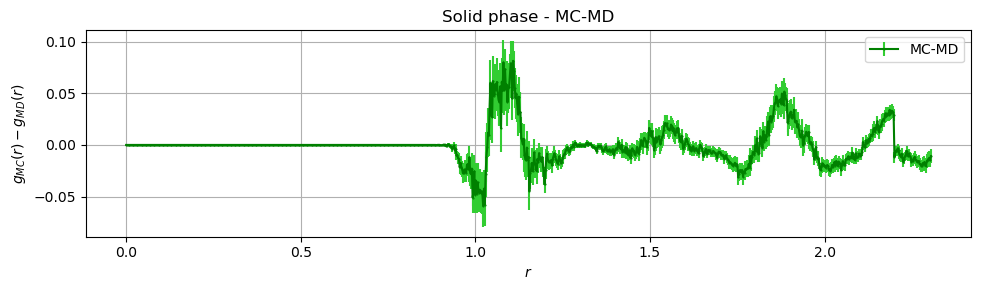

In [27]:
#SOLID
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'green')
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Solid phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, label = "Simulation MC", color = 'green')
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Solid phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()

#SOLID - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC', color = 'green')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_solid_0.80_gdr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'limegreen')
plt.title('Solid phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', color = 'green', ecolor = 'limegreen')
plt.title('Solid phase - MC-MD')
plt.ylabel('$g_{MC}(r)-g_{MD}(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Limitandosi ad un'analisi sui grafici della differenza $g_{MC}(r)-g_{MD}(r)$ si può affermare che le simulazioni sono ben compatibili tra loro. Questo fornisce una buona conferma del fatto che gli algoritmi utilizzati simulino in modo appropriato e senza eroori di codice le caratteristiche di un sistema reale.